# Reading NetCDF's using Pandas DataFrame
## Satellite Image Processing / BioCAST Seed Creation

Includes references to plotting using Matplotlib and related tools.

This program reads in two inputs: 1) APS level 4 satellite image 7 Day composite 2) BioCast generated advection product.  Both are NetCDF's.
The program's goal is to read the inputs, store them, and perform a union of the data with a basic gaussian smoothing to create a "full" image (sometimes a problem due to cloud coverage).
Output the data using NetCDF Best Practices, APS meta-data as an authoritative source, and custom meta-data geared towards future requirements.

In [1]:
# Python 3.7.3
############################################
# INCLUDES
############################################
#libraries specific to this example
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as matplt
import matplotlib.pyplot as plt

#a set of libraries that perhaps should always be in Python source
import os 
import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings

#a darn useful library for creating paths and one I recommend you load to your environment
from pathlib import Path

from pydoc import help                          # can type in the python console `help(name of function)` to get the documentation

#Data Science Libraries
import numpy as np
import pandas as pd
import scipy as sp
import scipy.ndimage

#Plotting libraries
import matplotlib as matplt
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

# for NetCDF output
import netCDF4 as nc
from netCDF4 import Dataset

#Import a custom library, in this case a fairly useful logging framework
debug_lib_location = Path("./")
sys.path.append(str(debug_lib_location))
import debug

warnings.filterwarnings('ignore')               # don't print out warnings


root_location="." + os.sep + "data";

In [2]:
############################################
#JUPYTER NOTEBOOK OUTPUT CONTROL / FORMATTING
############################################
#set floating point to 4 places to things don't run loose
pd.options.display.float_format = '{:,.4f}'.format
np.set_printoptions(precision=4)

# Variable declaration

In [3]:
############################################
# GLOBAL VARIABLES
############################################
DEBUG = 1                            #General ledger output so you know what's happening.
DEBUG_DATA = 1                       #Extremely verbose output, change to zero (0) to supress the volume of output.

# CODE CONSTRAINTS
VERSION_NAME    = "OFM_seed_generator"
VERSION_ACRONYM = "OFMSG"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = 1
VERSION_TITLE   = VERSION_NAME + " (" + VERSION_ACRONYM + ") " + str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE) + " generated SEED."

FILL_VALUE=-32767.0 
ENCODING  ="utf-8"
############################################
# GLOBAL CONSTANTS
############################################
MINIMAL_VALUE=0.0001                  #Normally a _FillValue would be used but different NetCDF implementations 
                                      #are treating some values differently or don't even have the concept.
METADATA_DESCRIPTION = "Product composite using a daily satellite image coupled with a BioCast background field; used to SEED the optical field."    
METADATA_DISTRIBUTION= "Distribution Statement A: Approved for public release; distribution unlimited."
METADATA_REFERENCES  = "None"
METADATA_INSTITUTION = "Naval Research Lab (NRL)"
METADATA_SOURCE      = VERSION_NAME + " (" + VERSION_ACRONYM + ") " + str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE)
METADATA_COMMENT     = "None"    
    

############################################
# APPLICATION VARIABLES
############################################
aps_filename  = ""                     #APS NetCDF (daily file) filename
aps_df        = pd.DataFrame()         #Dataframe that holds APS geospatial data
aps_products  = {}                     #Dictionary of "products" each encapsulated in a dataframe

biocast_filename= ""                   #BIOCAST NetCDF Tau 0 (initial forecast), background (to fill in APS)
biocast_panda   = pd.DataFrame()       #Dataframe that holds BIOCAST geospatial data
biocast_products={}                    #Dictionary of "Products" each encapsulated in a dataframe

output_filename = ""
output_panda    = pd.DataFrame()
output_products={}

todayIs = datetime.datetime.now()
date_to_process = todayIs
clobber = "false"
aps_variable_domain=[]
biocast_variable_domain=[]
output_variable_domain=[]

netcdf_metadata={}

geospatial_lat_nm='lat'
geospatial_lon_nm='lon'
aps_lat_nm="y"
aps_lon_nm="x"
#note x,y values are shown below as they are part of the APS meta-data
#based on the NetCDF Best Practice subject x,y vars should not exist.
#keeping for continuity between BIOCAST code already written to read APS input.
geospatial_vars = [geospatial_lat_nm, geospatial_lon_nm, aps_lat_nm, aps_lon_nm]

############################################
# GLOBAL CONFIGURATION
############################################
os.environ['PYTHONIOENCODING']=ENCODING


# Define some Environment Variables

In [4]:
#temporary environment variable declaration
os.environ["NETCDF_METADATA_nm_title"]="title";                                      
os.environ["NETCDF_METADATA_nm_create_date"]="createDate";                           
os.environ["NETCDF_METADATA_nm_rp_org"]="rp_organization";                           
os.environ["NETCDF_METADATA_nm_rp_name"]="rp_name";                                  
os.environ["NETCDF_METADATA_nm_rp_phone"]="rp_phone";                                
os.environ["NETCDF_METADATA_nm_rp_email"]="rp_email";                                
os.environ["NETCDF_METADATA_nm_conventions"]="conventions";                          
os.environ["NETCDF_METADATA_val_title"]="";
os.environ["NETCDF_METADATA_val_create_date"]="";
os.environ["NETCDF_METADATA_val_rp_org"]="Naval Research Lab (NRL)";
os.environ["NETCDF_METADATA_val_rp_name"]="Christopher G Wood";
os.environ["NETCDF_METADATA_val_rp_phone"]="228-688-4755";
os.environ["NETCDF_METADATA_val_rp_email"]="christopher.wood@nrlssc.navy.mil";
os.environ["NETCDF_METADATA_val_conventions"]="National System for Geospatial Integlligence (NSG) Meatadata Foundation (NMF), Version 3.0, 2016-08-31 (NGA.STD.0012-3.0)"
os.environ["NETCDF_METADATA_nm_nb_latitude"]="geoBoundingBox_northBoundLatitude";  
os.environ["NETCDF_METADATA_nm_sb_latitude"]="geoBoundingBox_southBoundLatitude";  
os.environ["NETCDF_METADATA_nm_eb_longitude"]="geoBoundingBox_eastBoundLongitude"; 
os.environ["NETCDF_METADATA_nm_wb_longitude"]="geoBoundingBox_westBoundLongitude"; 
os.environ["NETCDF_METADATA_nm_geo_desc"]="geoDescription";                        
os.environ["NETCDF_METADATA_nm_refsys_code"]="referenceSystem_code";               
os.environ["NETCDF_METADATA_nm_refsys_title"]="referenceSystem_title";             
os.environ["NETCDF_METADATA_val_nb_latitude"]="";
os.environ["NETCDF_METADATA_val_sb_latitude"]="";
os.environ["NETCDF_METADATA_val_eb_longitude"]="";
os.environ["NETCDF_METADATA_val_wb_longitude"]="";
os.environ["NETCDF_METADATA_val_geo_desc"]="Pseudo-Mercator";
os.environ["NETCDF_METADATA_val_refsys_code"]="Geodetic Geographic 3D";
os.environ["NETCDF_METADATA_val_refsys_title"]="EPSG:4326 (WGS 84)";
os.environ["NETCDF_METADATA_nm_start_date"]="start_date";                          
os.environ["NETCDF_METADATA_nm_start_time"]="start_time";                         
os.environ["NETCDF_METADATA_nm_stop_date"]="stop_date";                          
os.environ["NETCDF_METADATA_nm_stop_time"]="stop_time";                         
os.environ["NETCDF_METADATA_val_start_date"]=""
os.environ["NETCDF_METADATA_val_start_time"]="";
os.environ["NETCDF_METADATA_val_stop_date"]="";
os.environ["NETCDF_METADATA_val_stop_time"]="";
os.environ["NETCDF_METADATA_nm_lineage"]="lineage";                                  
os.environ["NETCDF_METADATA_val_lineage"]="";
os.environ["NETCDF_METADATA_nm_ism_diststatement"]="ism_NoticeText";                 
os.environ["NETCDF_METADATA_nm_ism_class"]="ism_classification";                     
os.environ["NETCDF_METADATA_nm_ism_ownerproducer"]="ism_ownerProducer";              
os.environ["NETCDF_METADATA_val_ism_diststatement"]="Distribution Statement A: Approved for public release; distribution unlimited.";
os.environ["NETCDF_METADATA_val_ism_class"]="Unclassified";
os.environ["NETCDF_METADATA_val_ism_ownerproducer"]="USA";

# Function Declaration (lots of functions)

In [5]:
############################################
# WARNING / ERROR Management
############################################
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


############################################
# FUNCTIONS
############################################

def prototype(incMonth):

    debug.msg_info("Entering {}.{}".format(__name__, inspect.stack()[0][3]))
    debug.msg_info("The month you passed in was " + str(incMonth))
    debug.msg_info("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))
    return 1


def get_full_version():

    resultant = str(VERSION_NAME) + "  v" + str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE)
    return resultant

def get_version():

    resultant = str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE)
    return resultant

def printversion():

    print(get_full_version())

def printusage():

    print("")
    printversion()
    print("  -v, --version    prints the version of this software package.")
    print("  -o, --ofile  =  *name of the NetCDF output file (seed for 3DOG ingest).")
    print("  -a, --afile  =  *name of the NetCDF input file (APS generated lvl4 file).")
    print("  -b, --bfile  =  *name of the NetCDF BIOCAST input file (BIOCAST generated, Tau 0).")
    print("  -c, --clobber=   overwrite existing output file.")
    print("")
    print("  * - indicates required argument.")

def show_columns_plain(inc_ary):
    new_ary = []
    for col in inc_ary:
        new_ary.append(np.char.lower(col))
    new_ary.sort
    myOutputString = " "
    for col in new_ary:
        myOutputString = myOutputString + " " + str(col)
    return myOutputString

def show_columns_true(inc_ary):
    new_ary = []
    for col in inc_ary:
        new_ary.append(col)
    new_ary.sort
    myOutputString = " "
    for col in new_ary:
        myOutputString = myOutputString + " " + str(col)
    return myOutputString

def lib_diagnostics():
    debug.msg_debug("System version    #:{:>12}".format(sys.version))
    netcdf4_version_info = nc.getlibversion().split(" ")
    debug.msg_debug("netCDF4 version   #:{:>12}".format(netcdf4_version_info[0]))
    debug.msg_debug("Matplotlib version#:{:>12}".format(matplt.__version__))
    debug.msg_debug("Numpy version     #:{:>12}".format(np.__version__))
    debug.msg_debug("Pandas version    #:{:>12}".format(pd.__version__))
    debug.msg_debug("SciPy version     #:{:>12}".format(sp.__version__))

    return

###
# valid string:
#  We don't want the following:
#   - at the start of the file name (might be construed as a switch)
#  $, &, |, ;, <, >, `, !, *, ", \ (to start with)
###
def validstring(testsubject):

    if testsubject[0] == "-":
        return 0
    elif "$" in testsubject or "&" in testsubject or "|" in testsubject:
        return 0
    elif ";" in testsubject or "`" in testsubject or "!" in testsubject:
        return 0
    elif "*" in testsubject or '"' in testsubject or "\\" in testsubject:
        return 0
    else:
        return 1


def inputusage(flag):

    print("")
    printversion()
    if flag == "input":
        print("Input filename must reference a real file and cannot contain:")
        print('  $, &, |, ;, <, >, `, !, *, ", \ ')
        print("  or start with the character - ")
    elif flag == "biocast":
        print("BIOCAST Input filename must reference a real file and cannot contain:")
        print('  $, &, |, ;, <, >, `, !, *, ", \ ')
        print("  or start with the character - ")
    elif flag == "output":
        print("Output filename must not exist and cannot contain:")
        print('  $, &, |, ;, <, >, `, !, *, ", \ ')
        print("  or start with the character - ")
        print(" Set -c or --clobber to overwrite existing file.")
    elif flag == "collision":
        print("Input file(s) and/or output file cannot be the same.")
        print("...You were joking right?")
    else:
        print("Undefined input error.")


def failure_management(inc_reason, inc_exception):
    debug.msg_warning("Exception:")
    debug.msg_warning("...." + str(inc_exception))
    debug.msg_warning("")
    debug.msg_warning(inc_reason)
    printusage()
    exit(1)


def argument_management(inc_opts, inc_args):

    global date_to_process, aps_filename, biocast_filename, output_filename, area, clobber

    insufficient_args = "Unable to process the seed as insufficient command line parameters were passed."

    for opt, arg in inc_opts:
        if opt == "-h":
            printusage()
            sys.exit(2)
        elif opt in ("-a", "-A", "-ifile", "--ifile"):
            aps_filename = arg
        elif opt in ("-b", "-B", "-bfile", "--bfile"):
            biocast_filename = arg
        elif opt in ("-o", "-O", "-ofile", "--ofile"):
            output_filename = arg
        elif opt in ("-c", "--clobber"):
            clobber = arg
        elif opt in ("-V", "-v", "-version", "-Version", "--version", "--Version"):
            printversion()
            sys.exit(2)

            

    if clobber != "true" and clobber != "false":
        debug.msg_warning("Clobber is invalid.")
        debug.msg_warning(clobber)
        printusage()
        sys.exit(1)

    try:
        if ("aps_filename" in locals()) or ("aps_filename" in globals()) and (len(aps_filename) > 0):
            if DEBUG_DATA:
                debug.msg_debug(" APS Input file: " + str(aps_filename))
            if not validstring(aps_filename) or not os.path.isfile(aps_filename):
                debug.msg_warning("APS input filename is invalid or file doesn't exist.")
                inputusage("input")
                exit(1)
        else:
            debug.msg_warning(insufficient_args)
            printusage()
            exit(1)
    except Exception as e:
        failure_management(insufficient_args, str(e))

    try:
        if ("biocast_filename" in locals()) or ("biocast_filename" in globals()) and (len(biocast_filename) > 0):
            if DEBUG_DATA:
                debug.msg_debug(" BIOCAST Input file: " + str(biocast_filename))
            if not validstring(biocast_filename) or not os.path.isfile(biocast_filename):
                debug.msg_warning("BIOCAST Input filename is invalid or file doesn't exist.")
                inputusage("biocast")
                exit(1)
        else:
            debug.msg_warning(insufficient_args)
            printusage()
            exit(1)
    except Exception as e:
        failure_management(insufficient_args, str(e))

    try:
        if ("output_filename" in locals()) or ("output_filename" in globals()) and (len(output_filename) > 0):
            if DEBUG:
                debug.msg_debug("Output file: " + str(output_filename))
            if not validstring(output_filename) or (os.path.exists(output_filename) and clobber != "true"):
                debug.msg_warning("Output filename is invalid or file exists and clobber was not set.")
                inputusage("output")
                exit(1)
        else:
            debug.msg_warning("Unable to process the nowcast without an output file defined.")
            printusage()
            exit(1)
    except Exception as e:
        failure_management(insufficient_args, str(e))

    if output_filename == aps_filename:
        inputusage("collision")
        exit(1)

    if output_filename == biocast_filename:
        inputusage("collision")
        exit(1)

    if aps_filename == biocast_filename:
        inputusage("collision")
        exit(1)

def get_variable_domain(inc_dataset, inc_domain):
    if DEBUG:
        debug.msg_info("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

    #based on analysis of variables, the ProductUnits attribute is only present in those 
    #variables that have actual geophysical properties, a.k.a. true products
    for var in inc_dataset.get_variables_by_attributes(productUnits=lambda v: v is not None):
        inc_domain.append(var.name)

    if DEBUG:
        debug.msg_info("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))

def establish_common_domain(inc_aps_domain, inc_biocast_domain):

    if DEBUG:
        debug.msg_info("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

    for var in inc_aps_domain:
        if var in inc_biocast_domain:
            output_variable_domain.append(var)
            debug.msg_debug("...Found match between both:"+str(var))

    if DEBUG:
        debug.msg_info("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))

def show_netcdf_details(inc_dataset, inc_var_domain):
    if DEBUG:
        debug.msg_info("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

        try:
            debug.msg_debug(".......version:" + str(inc_dataset.data_model))
        except Exception as e:
            failure_management("While loading the model climatology a problem occurred.", str(e))

        if (inc_dataset.isopen):
          for attr in inc_var_domain:
            debug.msg_debug("........processing " + str(attr))
            try:
                variables=inc_dataset.get_variables_by_attributes(name=attr)
                for var in variables:
                    debug.msg_debug("................name:"+str(var.name))
                    debug.msg_debug("................dims:"+str(var.ndim))
                    debug.msg_debug("................type:"+str(var.dtype))
                    debug.msg_debug("...............shape:"+str(var.shape))
            except Exception as e:
                debug.msg_warning("Unable to gather details on variable:" + str(attr), str(e))

    if DEBUG:
        debug.msg_info("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))

def show_data(inc_dataframe):

    if isinstance(inc_dataframe, pd.DataFrame):
        try:
            if DEBUG_DATA:
                debug.msg_debug("--------------------------------------------------------------")
                debug.msg_info("Entering " + inspect.stack()[0][3])
                debug.msg_debug("HEAD")
                print(inc_dataframe.head())
                debug.msg_debug("TAIL")
                print(inc_dataframe.tail())
                debug.msg_debug("DESCRIBE")
                print(inc_dataframe.describe())
                debug.msg_debug("axes: {}".format(inc_dataframe.axes))
                debug.msg_debug("shape: {}".format(inc_dataframe.shape))
                debug.msg_debug("size: {}".format(inc_dataframe.size))
                debug.msg_info("Exiting " + inspect.stack()[0][3])
                debug.msg_debug("--------------------------------------------------------------")
        except Exception as e:
            debug.msg_warning("Unable to show details on the data frame passed.", str(e))
    else:
        debug.msg_warning("In show_data() the incoming dataframe was not a Pandas.DataFrame.")
        debug.msg_warning("This warning is shown but program execution will continue.")
    return

def create_output(inc_outputfilename, inc_lat_dim, inc_lon_dim, inc_depth_max, inc_depths, inc_fused_data):

    if DEBUG:
        debug.msg_info("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

    # dataset = Dataset(inc_outputfilename, 'w', format='NETCDF4_CLASSIC')
    dataset = netcdf.netcdf_file(inc_outputfilename, "w")

#    meta_data_input=str(PROJ) + " " + str(PROJ_AREA) + " Machine Learning Prediction " + str(VERSION_NAME) + "v" + str(get_version())
    meta_data_input="put something here"
    dataset.title = meta_data_input.encode(ENCODING, errors='ignore').strip()
    meta_data_input=" "
    dataset.subtitle = meta_data_input.encode(ENCODING, errors='ignore')

    depth = dataset.createDimension("depth", inc_depth_max)
    time = dataset.createDimension("time", 1)
    lat = dataset.createDimension("lat", inc_lat_dim)
    lon = dataset.createDimension("lon", inc_lon_dim)
    x = dataset.createDimension("x", inc_lat_dim)
    y = dataset.createDimension("y", inc_lon_dim)
    z = dataset.createDimension("z", inc_depth_max)

    lat_reference = dataset.createVariable("lat", "f8", ("lat",))
    # put units, long_name and other details
    lon_reference = dataset.createVariable("lon", "f8", ("lon",))
    # put units, long_name and other details
    depth_reference = dataset.createVariable("depths", "f8", ("depth",))
    # put units, long_name and other details

    netcdf_variable_output_domain = None
    netcdf_variable_output_domain = variable_output_domain.copy()
    netcdf_variable_output_domain.append("sat_CHL")
    netcdf_variable_output_domain.append("sat_sst")

    for var in netcdf_variable_output_domain:
        if DEBUG:
            debug.msg_debug("...Processing " + str(var))
        var_reference = dataset.createVariable(var, "f8", ("time", "depth", "lat", "lon"))
        # put units, long_name and other details

    if DEBUG_DATA:
        debug.msg_debug("  Output file name: " + str(inc_outputfilename))
        debug.msg_debug("        DIMENSIONS: ")
        for dimname in dataset.dimensions.keys():
            dim = dataset.dimensions[dimname]
            debug.msg_debug("...." + str(dimname) + ":" + str(dim))
        for varname in dataset.variables.keys():
            var = dataset.variables[varname]
            debug.msg_debug("...." + str(varname))
            # debug.msg_debug("...." + str(varname) + ":" + str(var.dtype) + " - " + str(var.dimensions) + " - " + str(var.shape))

    if DEBUG:
        debug.msg_info("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))
    return dataset


def create_navigation_netcdf_vars(inc_coordinate_hash, output_dataset, inc_DEPTHS):

    debug.msg_info("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

    if DEBUG:
        debug.msg_debug("...latitude")
    lat_netcdf_variable = output_dataset.variables["lat"]
    lat_array = inc_coordinate_hash["lat"]
    lat_netcdf_variable[:] = lat_array

    if DEBUG:
        debug.msg_debug("...longitude")
    lon_netcdf_variable = output_dataset.variables["lon"]
    lon_array = inc_coordinate_hash["lon"]
    lon_netcdf_variable[:] = lon_array

    if DEBUG:
        debug.msg_debug("...depths")
    depth_netcdf_variable = output_dataset.variables["depths"]
    depth_array = inc_DEPTHS
    depth_netcdf_variable[:] = depth_array

    debug.msg_info("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))


def show_data_distribution(inc_dict1, inc_dict2, inc_variable_domain, inc_name1, inc_name2, inc_outputfile_prefix):

    if DEBUG:
        debug.msg_info("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

    for var in inc_variable_domain:
        matplt.use('Agg')
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(1, 1, 1)
        #inc_dataframe[var].hist(bins=10, grid=True)
        sns.distplot(inc_dict1[var], label=inc_name1, kde=False, bins=10)
        sns.distplot(inc_dict2[var], label=inc_name2, kde=False, bins=10)
        plt.legend(prop={'size':12})
        plt.xlabel(str(var), fontsize=15)
        plt.ylabel("Frequency", fontsize=15)
        plt.title(str(var) + " Distribution", fontsize=18)
        output_filename=str(inc_outputfile_prefix) + "_" + str(var) + "_map.png"
        plt.savefig(output_filename)
        plt.close()

    if DEBUG:
        debug.msg_info("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))

def show_map_coverage(inc_dataframe_reference, inc_dataframe, inc_name):

    if DEBUG:
        debug.msg_info("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

    coordinate_offset=0.5
    new_df = inc_dataframe
    TARGET_DATAFRAME = inc_dataframe_reference

    central_longitude       = np.median(TARGET_DATAFRAME[geospatial_lon_nm])
    central_latitude        = np.median(TARGET_DATAFRAME[geospatial_lat_nm])
    west                    = np.min(TARGET_DATAFRAME[geospatial_lon_nm]) - coordinate_offset
    east                    = np.max(TARGET_DATAFRAME[geospatial_lon_nm]) + coordinate_offset
    north                   = np.max(TARGET_DATAFRAME[geospatial_lat_nm]) + coordinate_offset
    south                   = np.min(TARGET_DATAFRAME[geospatial_lat_nm]) - coordinate_offset

    slice_central_longitude = new_df[geospatial_lon_nm].median()
    slice_central_latitude  = new_df[geospatial_lat_nm].median()
    slice_west              = new_df[geospatial_lon_nm].min() - coordinate_offset
    slice_east              = new_df[geospatial_lon_nm].max() + coordinate_offset
    slice_north             = new_df[geospatial_lat_nm].max() + coordinate_offset
    slice_south             = new_df[geospatial_lat_nm].min() - coordinate_offset

    if (DEBUG_DATA):
        debug.msg_debug("    {}      {}".format("Coord Hash", "Depth Slice"))
        debug.msg_debug("{}  {}      {}".format("Cent Long", central_longitude, slice_central_longitude))
        debug.msg_debug("{}  {}      {}".format("Cent Lat", central_latitude, slice_central_latitude))
        debug.msg_debug("{}  {}      {}".format("West", west, slice_west))
        debug.msg_debug("{}  {}      {}".format("East", east, slice_east))
        debug.msg_debug("{}  {}      {}".format("North", north, slice_north))
        debug.msg_debug("{}  {}      {}".format("South", south, slice_south))

    matplt.use('Agg')
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Miller())
    ax.set_extent([west, east, south, north])
    ax.coastlines()
    ax.stock_img()
    ax.gridlines()
    ax.add_wms(wms="http://vmap0.tiles.osgeo.org/wms/vmap0", layers=["basic"])

    DATA_COLOR = "red"
    DATA_SIZE = 0.10

    ax.scatter(new_df[geospatial_lon_nm], new_df[geospatial_lat_nm], c=DATA_COLOR, s=DATA_SIZE)

    output_filename=str(inc_name) + "_map.png"
    debug.msg_debug("Graphics output filename:"+str(output_filename))
    plt.savefig(output_filename)
    plt.close()

    if DEBUG:
        debug.msg_info("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))
 
def take_out_trash():
    if (gc.isenabled()):
        try:
            gc.collect()
        except Exception as e:
            debug.msg_warning("Unable to garbage collect.")
    else:
        try:
            gc.enable()
            gc.collect()
        except Exception as e:
            debug.msg_warning("Tried to turn on automatic garbage collection and collect but failed.")

def gather_aps_metadata(inc_auth_netcdf):

    if DEBUG:
        debug.msg_info("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

    #set global attribution, copy the originating APS NetCDF and replicate
    try:
        global_name_list=inc_auth_netcdf.ncattrs()
    except Exception as e:
            debug.msg_warning("Unable to invoke .ncattrs on the APS netcdf file in {}.{}.".format(__name__, inspect.stack()[0][3]))    
        
    debug.msg_debug("...gathering and posting APS global attribution")
    value=""
    for name in global_name_list:
        try:
            value=inc_auth_netcdf.getncattr(name)
            debug.msg_debug("..........{} -> {}".format(name, value))
        except Exception as e:
            debug.msg_warning("Unable to invoke .getncattr({}) on the APS netcdf file in {}.{}.".format(name,__name__, inspect.stack()[0][3]))    
        netcdf_metadata[name]=value
        
    debug.msg_debug("...finished gathering and posting APS global attribution")
    
    if DEBUG:
        debug.msg_info("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))        
        
def load_project_meta_data():
    if DEBUG:
        debug.msg_info("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

    #assumes exposure of environmental variables from OFM Consolidated System (regional meta-data environment file)
    #design is to fail gracefully with logging (warn) in case environment file is not loaded
    #example:
    #    export NETCDF_METADATA_nm_title="title";                                      #Name of file (perhaps includes content)
    env_var_names=["title", "create_date", "rp_org", "rp_name", "rp_phone", "rp_email", "conventions", "nb_latitude", "sb_latitude", "eb_longitude", "wb_longitude",
                "geo_desc", "refsys_code", "refsys_title", "ism_diststatement", "ism_class", "ism_ownerproducer"]
    
    for var_name in env_var_names:
        if (DEBUG_DATA):
            debug.msg_debug("......{}".format(var_name))
        try:
            metadata_name=os.getenv("NETCDF_METADATA_nm_"+str(var_name))
            metadata_value=os.getenv("NETCDF_METADATA_val_"+str(var_name))
            netcdf_metadata[metadata_name]=metadata_value.encode(ENCODING,errors='ignore').strip()
        except Exception as e:
            debug.msg_warning("{} environmental variable not found in {}.{}.".format(var_name, __name__, inspect.stack()[0][3]))

    if DEBUG:
        debug.msg_info("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))    
        
def post_all_metadata (out_netcdf):

    if DEBUG:
        debug.msg_info("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

    debug.msg_debug("...starting iteration through netcdf dictionary")

    #iterate through the data and push it to the netcdf now
    for key in netcdf_metadata:
        try:
            out_netcdf.setncattr(key, netcdf_metadata[key])
        except Exception as e:
            debug.msg_warning("Unable to invoke .setncattr({}) on the output netcdf file in {}.{}.".format(key,__name__, inspect.stack()[0][3]))    
            
    debug.msg_debug("...finished iteration through netcdf dictionary")
    
    if DEBUG:
        debug.msg_info("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))       
        
def post_metadata(auth_dataset, out_dataset):
    if DEBUG:
        debug.msg_info("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

    #load the project level NetCDF meta-data
    load_project_meta_data()
    
    try:
        # MINIMAL ATTRIBUTES (NetCDF Best Practices and CF), ensures nothing is missing from project netcdf meta-data
        metadata_name="create_date"
        metadata_input=str(datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S"))
        final_metadata_input = metadata_input.encode(ENCODING,errors='ignore').strip()
        netcdf_metadata[metadata_name]=final_metadata_input
    except Exception as e:
            debug.msg_warning("{} unable to set metadata attribute {} in {}.{} to the dictionary.".format(metadata_name, var_name, __name__, inspect.stack()[0][3]))    
        
    #history
    try:
        metadata_name="history"
        metadata_input=str("Created with " + str(get_version()))
        final_metadata_input = metadata_input.encode(ENCODING,errors='ignore').strip()
        netcdf_metadata[metadata_name]=final_metadata_input
    except Exception as e:
            debug.msg_warning("{} unable to set metadata attribute {} in {}.{} to the dictionary.".format(metadata_name, var_name, __name__, inspect.stack()[0][3]))    
        
    #title
    try:
        metadata_name="title"
        if (metadata_name in netcdf_metadata.keys()):
            if (len(netcdf_metadata[metadata_name])> 0):
                metadata_input = netcdf_metadata[metadata_name]
        else:
            metadata_input =  VERSION_TITLE    
        netcdf_metadata[metadata_name]=metadata_input        
    except Exception as e:
            debug.msg_warning("{} unable to set metadata attribute {} in {}.{} to the dictionary.".format(metadata_name, var_name, __name__, inspect.stack()[0][3]))    
    
    #description
    try:
        metadata_name="description"
        if (metadata_name in netcdf_metadata.keys()):
            if (len(netcdf_metadata[metadata_name])> 0):
                metadata_input = netcdf_metadata[metadata_name]
        else:
            metadata_input =  METADATA_DESCRIPTION  
        netcdf_metadata[metadata_name]=metadata_input        
    except Exception as e:
            debug.msg_warning("{} unable to set metadata attribute {} in {}.{} to the dictionary.".format(metadata_name, var_name, __name__, inspect.stack()[0][3]))    
       

    #distribution statement
    try:
        metadata_name="distribution_statement"
        if (metadata_name in netcdf_metadata.keys()):
            if (len(netcdf_metadata[metadata_name])> 0):
                metadata_input = netcdf_metadata[metadata_name]
        else:
            metadata_input =  METADATA_DISTRIBUTION
        netcdf_metadata[metadata_name]=metadata_input        
    except Exception as e:
            debug.msg_warning("{} unable to set metadata attribute {} in {}.{} to the dictionary.".format(metadata_name, var_name, __name__, inspect.stack()[0][3]))    
   
    #references
    try:
        metadata_name="references"
        if (metadata_name in netcdf_metadata.keys()):
            if (len(netcdf_metadata[metadata_name])> 0):
                metadata_input = netcdf_metadata[metadata_name]
        else:
            metadata_input =  METADATA_REFERENCES
        netcdf_metadata[metadata_name]=metadata_input        
    except Exception as e:
            debug.msg_warning("{} unable to set metadata attribute {} in {}.{} to the dictionary.".format(metadata_name, var_name, __name__, inspect.stack()[0][3]))    

    #institution
    try:
        metadata_name="institution"
        if (metadata_name in netcdf_metadata.keys()):
            if (len(netcdf_metadata[metadata_name])> 0):
                metadata_input = netcdf_metadata[metadata_name]
        else:
            metadata_input =  METADATA_INSTITUTION
        netcdf_metadata[metadata_name]=metadata_input        
    except Exception as e:
            debug.msg_warning("{} unable to set metadata attribute {} in {}.{} to the dictionary.".format(metadata_name, var_name, __name__, inspect.stack()[0][3]))    
        
    #source
    try:
        metadata_name="source"
        if (metadata_name in netcdf_metadata.keys()):
            if (len(netcdf_metadata[metadata_name])> 0):
                metadata_input = netcdf_metadata[metadata_name]
        else:
            metadata_input =  METADATA_SOURCE
        netcdf_metadata[metadata_name]=metadata_input        
    except Exception as e:
            debug.msg_warning("{} unable to set metadata attribute {} in {}.{} to the dictionary.".format(metadata_name, var_name, __name__, inspect.stack()[0][3]))    
    
    #comment
    try:
        metadata_name="comment"
        if (metadata_name in netcdf_metadata.keys()):
            if (len(netcdf_metadata[metadata_name])> 0):
                metadata_input = netcdf_metadata[metadata_name]
        else:
            metadata_input =  METADATA_COMMENT
        netcdf_metadata[metadata_name]=metadata_input        
    except Exception as e:
            debug.msg_warning("{} unable to set metadata attribute {} in {}.{} to the dictionary.".format(metadata_name, var_name, __name__, inspect.stack()[0][3]))    

    #take the original APS data and push (as authoritative) into the NetCDF output file
    debug.msg_debug("...gathering aps meta-data, as authoritative.")
    gather_aps_metadata(auth_dataset)

    ####################################################################################################################################
    #custom changes, metadata APS has that should be in the default/required Global attribution
    #source = "OFM_seed_generator (OFMSG) 0.0.1" ;
    try:
        source=[]
        source.append(netcdf_metadata['inputParameters'] + " from the following files: " + netcdf_metadata['inputFiles'])
        source.append(netcdf_metadata[os.getenv("NETCDF_METADATA_nm_rp_org")])     #long term standards
        source.append(netcdf_metadata['file'])                                     #APS value
        source.append(netcdf_metadata["geospatial_lat_max"])                       #APS value
        source.append(netcdf_metadata["geospatial_lat_min"])                       #APS value
        source.append(netcdf_metadata["geospatial_lon_max"])                       #APS value
        source.append(netcdf_metadata["geospatial_lon_min"])                       #APS value
        source.append(", ".join(output_variable_domain))
        source.append(netcdf_metadata['inputParameters'] + " from the following files: " + netcdf_metadata['inputFiles'])
        source.append(netcdf_metadata['ism_NoticeText'])                           #Long term standard, alreadyloaded

        target=['history', 'institution', 'source']                                #CF / NetCDF Best Practices
        target.append(os.getenv("NETCDF_METADATA_nm_nb_latitude"))                 #long term standards
        target.append(os.getenv("NETCDF_METADATA_nm_sb_latitude"))                 #long term standards
        target.append(os.getenv("NETCDF_METADATA_nm_eb_longitude"))                #long term standards
        target.append(os.getenv("NETCDF_METADATA_nm_wb_longitude"))                #long term standards
        target.append('prodList')                                                  #corrected because this is the intersection of two files
        target.append('lineage')                                                   #long term standards
        target.append('distribution_statement')                                    #standard classification concern


        for idx in range(0, len(target)):
            try:
                metadata_name=target[idx]
                netcdf_metadata[metadata_name]=source[idx]  #default within consolidated source metadata env vars
            except Exception as e:
                debug.msg_warning("Unable to set metadata attribute {} from {} in {}.{} to the dictionary.".format(metadata_name, target_key, __name__, inspect.stack()[0][3]))    
    except Exception as e:
            debug.msg_warning("Failed to set custom attribution, some meta-data is likely changed or missing from a source document in {}.{}.".format( __name__, inspect.stack()[0][3]))    
        
    ####################################################################################################################################    
        
    #final write
    debug.msg_debug("...write the actual output to the file.")
    post_all_metadata(out_dataset)

    if DEBUG:
        debug.msg_info("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))        

# Main Method - setup environment to support program execution
## Define filenames

In [6]:
############################################
# MAIN
############################################
#try:
#     opts, args = getopt.getopt(
#          argv, "VvHhB:b:A:a::O:o:c:", ["afile=", "bfile=", "ofile=", "clobber="]
#      )
#except getopt.GetoptError:
#      printusage()
#      sys.exit(2)
#argument_management(opts, args)

warnings.filterwarnings("ignore")


#Setup filenames
aps_filename    =root_location+os.sep+"npp.201997.MMDD.2019103.0413.D.L4-7DLP.viirsn.MissBight.v08.750m.nc"
biocast_filename=root_location+os.sep+"MissBight_2020010900.nc"
output_filename =root_location+os.sep+"example_seed.nc"


debug.msg_info("Started " + str(VERSION_NAME) + ".")

debug.msg_info(" ")
debug.msg_debug("...library versioning output")
lib_diagnostics()
debug.msg_info(" ")
debug.msg_debug("    APS Filename: "+aps_filename)
debug.msg_debug("BioCast Filename: "+biocast_filename)


[2022-09-07 16:27:21 CDT]    INFO: Started OFM_seed_generator. 
[2022-09-07 16:27:21 CDT]    INFO:   
[2022-09-07 16:27:21 CDT]   DEBUG: ...library versioning output 
[2022-09-07 16:27:21 CDT]   DEBUG: System version    #:3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0] 
[2022-09-07 16:27:21 CDT]   DEBUG: netCDF4 version   #:       4.7.4 
[2022-09-07 16:27:21 CDT]   DEBUG: Matplotlib version#:       3.4.2 
[2022-09-07 16:27:21 CDT]   DEBUG: Numpy version     #:      1.21.1 
[2022-09-07 16:27:21 CDT]   DEBUG: Pandas version    #:       1.3.1 
[2022-09-07 16:27:21 CDT]   DEBUG: SciPy version     #:       1.7.1 
[2022-09-07 16:27:21 CDT]    INFO:   
[2022-09-07 16:27:21 CDT]   DEBUG:     APS Filename: ./data/npp.201997.MMDD.2019103.0413.D.L4-7DLP.viirsn.MissBight.v08.750m.nc 
[2022-09-07 16:27:21 CDT]   DEBUG: BioCast Filename: ./data/MissBight_2020010900.nc 


# Read Input NetCDF Files

In [7]:
#READ Input NetCDF
#argument management has already handled existence, validity, etc.

#write defensive code that fails fast, use try/exceptions where it makes sense.
try:
    aps_netcdf = Dataset(aps_filename, "r", format="NETCDF4")
    #note that APS output is not packed
    aps_netcdf.set_auto_scale(True)
except Exception as e:
    failure_management("Error encountered while reading initial NetCDF", str(e))

if (DEBUG_DATA):
    debug.msg_debug("NetCDF (aps) opened.")
    get_variable_domain(aps_netcdf, aps_variable_domain)
    show_netcdf_details(aps_netcdf, aps_variable_domain)

try:
    biocast_netcdf = Dataset(biocast_filename, "r", format="NETCDF4")
    #note that BIOCAST output is not packed
    biocast_netcdf.set_auto_scale(True)
except Exception as e:
    failure_management("Error encountered while reading initial BIOCAST NetCDF", str(e))

if (DEBUG_DATA):
    debug.msg_debug("NetCDF (biocast) opened.")
    get_variable_domain(biocast_netcdf, biocast_variable_domain)
    show_netcdf_details(biocast_netcdf, biocast_variable_domain)


[2022-09-07 16:27:26 CDT]   DEBUG: NetCDF (aps) opened. 
[2022-09-07 16:27:27 CDT]    INFO: Entering __main__.get_variable_domain 
[2022-09-07 16:27:27 CDT]    INFO: Exiting __main__.get_variable_domain 
[2022-09-07 16:27:27 CDT]    INFO: Entering __main__.show_netcdf_details 
[2022-09-07 16:27:27 CDT]   DEBUG: .......version:NETCDF4 
[2022-09-07 16:27:27 CDT]   DEBUG: ........processing salinity 
[2022-09-07 16:27:27 CDT]   DEBUG: ................name:salinity 
[2022-09-07 16:27:27 CDT]   DEBUG: ................dims:2 
[2022-09-07 16:27:27 CDT]   DEBUG: ................type:int16 
[2022-09-07 16:27:27 CDT]   DEBUG: ...............shape:(400, 800) 
[2022-09-07 16:27:27 CDT]   DEBUG: ........processing chlor_a 
[2022-09-07 16:27:27 CDT]   DEBUG: ................name:chlor_a 
[2022-09-07 16:27:27 CDT]   DEBUG: ................dims:2 
[2022-09-07 16:27:27 CDT]   DEBUG: ................type:float32 
[2022-09-07 16:27:27 CDT]   DEBUG: ...............shape:(400, 800) 
[2022-09-07 16:27:27 CD

# Build Panda.DataFrame() structures for data

In [8]:
#BUILD DATAFRAMES (Create common geospatial structure)
try:
    #iterate through the set of NetCDF variables in each input file
    #find the union of both variable sets, that's the most you can merge
    establish_common_domain(aps_variable_domain, biocast_variable_domain)
    output_variable_domain=['chlor_a']
except Exception as e:
    failure_management("Unable to match variables in APS to BIOCAST NetCDF.", str(e))

debug.msg_info("APS Coordinates to pd.DataFrame().")
#flatten the output from APS, which is a grid of points, and get the unique list of lats, that's Y
#technically APS outputs an x,y set of values that a 1D but that name is not consistent.
lat = np.array(aps_netcdf.variables[geospatial_lat_nm][:][:]).flatten()
lat = np.unique(lat)
lon = np.array(aps_netcdf.variables[geospatial_lon_nm][:][:]).flatten()
lon = np.unique(lon)

latSeries=pd.Series(lat)
lonSeries=pd.Series(lon)

#define a Panda.DataFrame()
frame={geospatial_lat_nm: latSeries, geospatial_lon_nm: lonSeries}

#instantiate a dataframe
aps_panda=pd.DataFrame(frame)

#ensure the data is cast as expected
aps_panda[geospatial_lat_nm].astype('float64')
aps_panda[geospatial_lon_nm].astype('float64')

#clean-up to ensure memory is kept minimal...not sure if this really matters.
del lat, lon, latSeries, lonSeries, frame

#biocast is a lat and lon of 1d, we're going to keep it that way
debug.msg_info("BIOCAST Coordinates to pd.DataFrame().")

#could access via lat=biocast_netcdf[geosptaial_lat_nm]
#            then print(lat[0]) for a value.
lat   =np.array(biocast_netcdf.variables[geospatial_lat_nm][:][:]).flatten()
lon   =np.array(biocast_netcdf.variables[geospatial_lon_nm][:][:]).flatten()
latSeries=pd.Series(lat)
lonSeries=pd.Series(lon)
frame={geospatial_lat_nm: latSeries, geospatial_lon_nm: lonSeries}
biocast_panda=pd.DataFrame(frame)
biocast_panda[geospatial_lat_nm].astype('float64')
biocast_panda[geospatial_lon_nm].astype('float64')

del lat, lon, latSeries, lonSeries, frame

#keep an independent geographic setup for output (to keep things consistent), but use BIOCAST as the basis for that system
debug.msg_info("Copy BIOCAST Coordinates to Output pd.DataFrame().")
output_panda = biocast_panda.copy()

take_out_trash()

[2022-09-07 16:27:32 CDT]    INFO: Entering __main__.establish_common_domain 
[2022-09-07 16:27:32 CDT]   DEBUG: ...Found match between both:chlor_a 
[2022-09-07 16:27:33 CDT]    INFO: Exiting __main__.establish_common_domain 
[2022-09-07 16:27:33 CDT]    INFO: APS Coordinates to pd.DataFrame(). 
[2022-09-07 16:27:33 CDT]    INFO: BIOCAST Coordinates to pd.DataFrame(). 
[2022-09-07 16:27:33 CDT]    INFO: Copy BIOCAST Coordinates to Output pd.DataFrame(). 


# Gather NetCDF Variable data and store for future use

In [9]:
#dictionary to hold 1 to N data frames of products.
for var in output_variable_domain:
    debug.msg_debug("Processing {}".format(var))
    varAry=np.array(aps_netcdf.variables[var][:][:])
    df = pd.DataFrame(data=varAry)
    aps_products[var]=df
    
    #handle cloud coverage by setting non-valid data to 0.0
    #note that _FillValue should be used by it has an "improper name"
    #and the value is set packed versus unpacked.
    aps_mangled=aps_products[var].values
    aps_fixed = np.where(aps_mangled > MINIMAL_VALUE, aps_mangled, 0.0)
    df = pd.DataFrame(data=aps_fixed)
    aps_products[var]=df

    varAry=np.array(biocast_netcdf.variables[var][0][0][:][:])
    df = pd.DataFrame(data=varAry)
    biocast_products[var] = df
    
#clean up varaible use    
del varAry, df

#force garbage collection, read the routine, this is not native.
take_out_trash()

[2022-09-07 16:27:37 CDT]   DEBUG: Processing chlor_a 


# Get a Quick view of the APS Product (Original)
## Note that `var` is the last variable processed in an array of potential products unioned between both inputs.

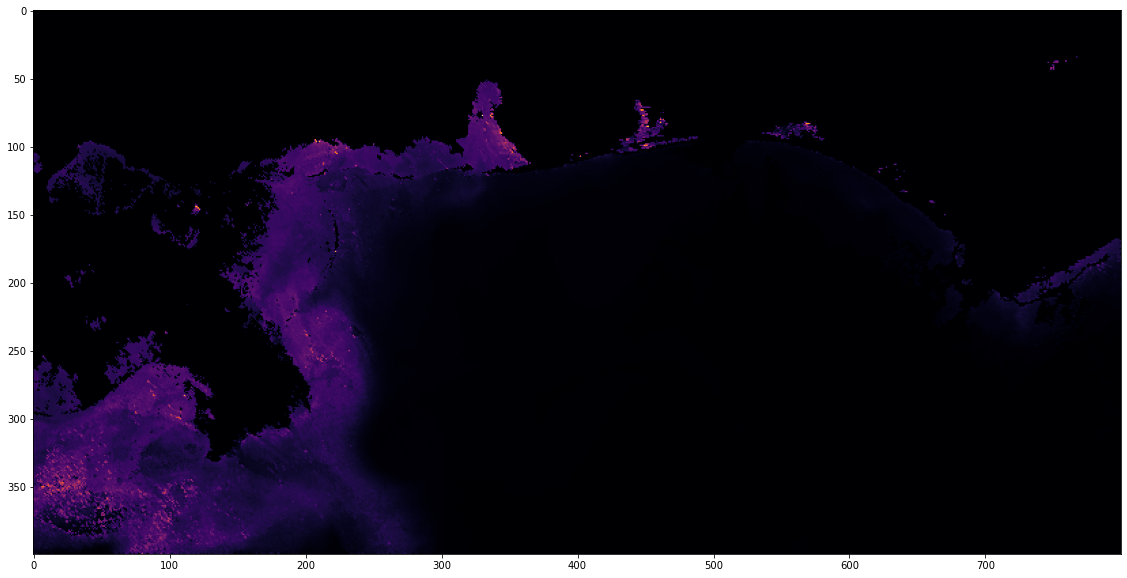

In [10]:
from matplotlib import pyplot as plt
plt.figure(figsize = (40,10))
plt.imshow(aps_products[var],cmap='inferno')

# Detailed debugging example
## Feel free to skip this execution.

In [11]:
for var in output_variable_domain:
    if (DEBUG_DATA):
        debug.msg_debug("APS columns:")
        aps_cols=show_columns_true(aps_products[var].columns)
        debug.msg_debug("APS DataFrame details:")
        show_data(aps_products[var])
        debug.msg_debug("..." + aps_cols)
        debug.msg_debug("BIOCAST columns:")
        biocast_cols=show_columns_true(biocast_products[var].columns)
        debug.msg_debug("BIOCAST DataFrame details:")
        show_data(biocast_products[var])
        debug.msg_debug("..." + biocast_cols)

try:
    del aps_cols, biocast_cols
    take_out_trash()
except Exception as e:
    print("IGNORE -> Failed to deallocate memory that wasn't used.", str(e))
    

[2022-09-07 16:27:45 CDT]   DEBUG: APS columns: 
[2022-09-07 16:27:45 CDT]   DEBUG: APS DataFrame details: 
[2022-09-07 16:27:45 CDT]   DEBUG: -------------------------------------------------------------- 
[2022-09-07 16:27:45 CDT]    INFO: Entering show_data 
[2022-09-07 16:27:45 CDT]   DEBUG: HEAD 
     0      1      2      3      4      5      6      7      8      9    ...  \
0 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  ...   
1 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  ...   
2 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  ...   
3 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  ...   
4 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  ...   

     790    791    792    793    794    795    796    797    798    799  
0 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  
1 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0

       0      1      2      3      4      5      6      7      8       9    \
395 6.4834 6.5998 7.3194 7.0382 6.1029 6.6354 6.7130 6.3333 7.7460  6.6283   
396 6.1286 6.7139 6.1762 5.6516 5.9799 6.3150 8.5380 7.1376 6.7390  7.2157   
397 6.6523 6.1044 5.6481 5.7622 5.7548 5.9685 8.6826 8.6347 6.3641  7.0594   
398 7.5150 6.6388 5.7614 7.0583 6.0969 7.3414 7.0997 7.0154 8.6785  6.9073   
399 6.8598 6.4476 6.7528 5.9258 6.8179 6.4679 2.5283 6.1938 8.5499 12.1956   

     ...    790    791    792    793    794    795    796    797    798    799  
395  ... 0.3454 0.3421 0.3339 0.3307 0.3510 0.3520 0.3317 0.3180 0.3406 0.3391  
396  ... 0.3174 0.3345 0.3426 0.3536 0.3567 0.3460 0.3357 0.3444 0.3266 0.3221  
397  ... 0.3221 0.3246 0.3281 0.3292 0.3337 0.3260 0.3155 0.3169 0.3190 0.3128  
398  ... 0.3264 0.3296 0.3442 0.3438 0.3381 0.3175 0.3206 0.3260 0.3235 0.3097  
399  ... 0.3344 0.3211 0.3295 0.3336 0.3303 0.3290 0.3196 0.3271 0.3207 0.3237  

[5 rows x 800 columns]
[2022-09-07 16:27:47 

# Product Merge
### Loop through each product in the dictionaries, look inside APS data and if you find a "gap" fill it with biocast saving results to the output_products dictionary

In [12]:
for var in output_variable_domain:
    debug.msg_info("Processing " + str(var))
    debug.msg_debug("...biocast shape " + str(biocast_products[var].values.shape))
    debug.msg_debug(".......aps shape " + str(aps_products[var].values.shape))
    outputAry_shape=biocast_products[var].values.shape
    lat_y = outputAry_shape[0]
    lon_x = outputAry_shape[1]
    outputAry = np.full([lat_y,lon_x],0.0)
    outputFilter = np.full([lat_y,lon_x],0.0)                               #Assign APS(1) versus BIOCAST (0) to a mask for a Convolution matrix
    debug.msg_debug("....output shape " + str(outputAry.shape))
    apsAry=aps_products[var].values
    biocastAry=biocast_products[var].values
    debug.msg_debug("....looping between datasets and assigning data to satellite coverage holes.")
    for index,value in np.ndenumerate(apsAry):
        if (value > MINIMAL_VALUE):
            outputAry[index]=value
            outputFilter[index]=1
        else:
            outputAry[index]=biocastAry[index]
    debug.msg_debug("....finished looping for " + str(var))
    
    debug.msg_debug("....applying gausian filter.")
    sigma_x = .5
    sigma_y = .5
    sigma = [sigma_y, sigma_x]
    outputAry=sp.ndimage.filters.gaussian_filter(outputAry, sigma, mode='constant')
    df = pd.DataFrame(data=outputAry)
    output_products[var]=df
try:
    del lat_y, lon_x, apsAry, biocastAry
    take_out_trash()
except Exception as e:
    print("IGNORE -> Failed to deallocate memory that wasn't used.", str(e))


[2022-09-07 16:27:53 CDT]    INFO: Processing chlor_a 
[2022-09-07 16:27:53 CDT]   DEBUG: ...biocast shape (400, 800) 
[2022-09-07 16:27:53 CDT]   DEBUG: .......aps shape (400, 800) 
[2022-09-07 16:27:53 CDT]   DEBUG: ....output shape (400, 800) 
[2022-09-07 16:27:53 CDT]   DEBUG: ....looping between datasets and assigning data to satellite coverage holes. 
[2022-09-07 16:27:53 CDT]   DEBUG: ....finished looping for chlor_a 
[2022-09-07 16:27:53 CDT]   DEBUG: ....applying gausian filter. 


# Create the output NetCDF
### Now that you have marshaled and merged all data, create the output NetCDF.

In [13]:
#CREATE Output NetCDF
#argument management has already handled existence, validity, etc.
try:
    output_netcdf = Dataset(output_filename, "w", format="NETCDF4")
    if DEBUG:
        debug.msg_debug("NetCDF write initiated.")
        debug.msg_debug(".......version:" + str(output_netcdf.data_model))
        
    post_metadata(aps_netcdf, output_netcdf)
                        
    #define dimensions using biocast as the model of basis
    debug.msg_debug(".......dimensions")
    for dim in aps_netcdf.dimensions.items():
        output_netcdf.createDimension(str(dim[1].name), int(dim[1].size))
        debug.msg_debug("............wrote " + str(dim[1].name) +" (" + str(dim[1].size) + ")")
        
    #explicitly define geospatial coordinates and then loop through "products"
    #calling dimensions is tricky with this API so explicit definitions vice dynamic coding is being used
    #marshal geospatial coordinates
    #debug.msg_debug(".......variables (aps geospatial)")
    #geospatial_output_domain=[aps_lat_nm, aps_lon_nm]
    #for name, variable in aps_netcdf.variables.items():            
    #    debug.msg_debug("......Processing {}".format(name))
    #    if (name in geospatial_output_domain):
    #        print(variable)
    #        debug.msg_debug(".........match found.")
    #        dims=variable.get_dims()
    #        debug.msg_debug("............dimensions obtained.")
    #        debug.msg_debug("netcdf_var=output_netcdf.createVariable({}, \"f8\", ({},) )".format(name, dims[0].name))
    #        netcdf_var=output_netcdf.createVariable(str(name), "f8", (dims[0].name,) )
    #        debug.msg_debug(".........copying attributes.")
    #        for attrname in variable.ncattrs():
    #            attrval=getattr(variable, attrname)
    #            netcdf_var.setncattr_string(attrname,attrval)
    #            debug.msg_debug("...............wrote {} = {}".format(attrname,attrval))
    #            #api call into the output netcdf
    #        if (aps_lat_nm == name):
    #            ys = np.linspace(1, dims[0].size-1, dims[0].size, dtype=int)
    #            netcdf_var[:] = ys[:]
    #        elif (aps_lon_nm == name):
    #            xs = np.linspace(1, dims[0].size, dims[0].size, dtype=int)
    #            netcdf_var[:] = xs[:]
   
    #del xs, ys

    #debug.msg_debug(".......variables (geospatial)")
    #geospatial_output_domain=[geospatial_lat_nm, geospatial_lon_nm]
    #for name, variable in aps_netcdf.variables.items():            
    #    if (name in geospatial_output_domain):
    #        dims=variable.get_dims()
    #        debug.msg_debug("netcdf_var=output_netcdf.createVariable({}, \"f8\", ({},) )".format(name,"\"lat\",\"lon\""))
    #        netcdf_var=output_netcdf.createVariable(str(name), "f8", ("lat","lon",) )
    #        debug.msg_debug("............{}".format(name))
    #        for attrname in variable.ncattrs():
    #            attrval=getattr(variable, attrname)
    #            netcdf_var.setncattr_string(attrname,attrval)
    #            debug.msg_debug("...............wrote {} = {}".format(attrname,attrval))
    #            #api call into the output netcdf
    #        if (geospatial_lat_nm == name):
    #            netcdf_var[:] = aps_netcdf.variables[geospatial_lat_nm][:][:]
    #        elif (geospatial_lon_nm == name):
    #            netcdf_var[:] = aps_netcdf.variables[geospatial_lon_nm][:][:]

 
    debug.msg_debug(".......variables (products)")
    final_output_domain=output_variable_domain
    for name, variable in aps_netcdf.variables.items():            
        if (name in final_output_domain):
            debug.msg_debug("netcdf_var=output_netcdf.createVariable({}, \"f8\", ({},) )".format(name, "\"lat\",\"lon\""))
            netcdf_var=output_netcdf.createVariable(str(name), "f8", ("lat","lon",) )
            debug.msg_debug("............{}".format(name))
            for attrname in variable.ncattrs():
                attrval=getattr(variable, attrname)
                netcdf_var.setncattr_string(attrname,attrval)
                debug.msg_debug("...............wrote {} = {}".format(attrname,attrval))
            netcdf_var.setncattr_string("_FillValue",-32767.0)                
            output_products[name].fillna(0.0)
            netcdf_var[:] = output_products[name].values
        
   
except Exception as e:
    failure_management("Error encountered while trying to write the output NetCDF", str(e))
                                                                      

[2022-09-07 16:27:55 CDT]   DEBUG: NetCDF write initiated. 
[2022-09-07 16:27:55 CDT]   DEBUG: .......version:NETCDF4 
[2022-09-07 16:27:55 CDT]    INFO: Entering __main__.post_metadata 
[2022-09-07 16:27:55 CDT]    INFO: Entering __main__.load_project_meta_data 
[2022-09-07 16:27:55 CDT]   DEBUG: ......title 
[2022-09-07 16:27:55 CDT]   DEBUG: ......create_date 
[2022-09-07 16:27:55 CDT]   DEBUG: ......rp_org 
[2022-09-07 16:27:55 CDT]   DEBUG: ......rp_name 
[2022-09-07 16:27:55 CDT]   DEBUG: ......rp_phone 
[2022-09-07 16:27:55 CDT]   DEBUG: ......rp_email 
[2022-09-07 16:27:55 CDT]   DEBUG: ......conventions 
[2022-09-07 16:27:55 CDT]   DEBUG: ......nb_latitude 
[2022-09-07 16:27:55 CDT]   DEBUG: ......sb_latitude 
[2022-09-07 16:27:55 CDT]   DEBUG: ......eb_longitude 
[2022-09-07 16:27:55 CDT]   DEBUG: ......wb_longitude 
[2022-09-07 16:27:55 CDT]   DEBUG: ......geo_desc 
[2022-09-07 16:27:55 CDT]   DEBUG: ......refsys_code 
[2022-09-07 16:27:55 CDT]   DEBUG: ......refsys_title 
[

[2022-09-07 16:27:55 CDT]   DEBUG: ............wrote samples (800) 
[2022-09-07 16:27:55 CDT]   DEBUG: ............wrote lon (800) 
[2022-09-07 16:27:55 CDT]   DEBUG: ............wrote lat (400) 
[2022-09-07 16:27:55 CDT]   DEBUG: ............wrote maps_len (29) 
[2022-09-07 16:27:55 CDT]   DEBUG: .......variables (products) 
[2022-09-07 16:27:55 CDT]   DEBUG: netcdf_var=output_netcdf.createVariable(chlor_a, "f8", ("lat","lon",) ) 
[2022-09-07 16:27:55 CDT]   DEBUG: ............chlor_a 
[2022-09-07 16:27:55 CDT]   DEBUG: ...............wrote productClass = geophysical parameter 
[2022-09-07 16:27:55 CDT]   DEBUG: ...............wrote productName = Chlorophyll Concentration, OCI Algorithm 
[2022-09-07 16:27:55 CDT]   DEBUG: ...............wrote productUnits = mg m^-3 
[2022-09-07 16:27:55 CDT]   DEBUG: ...............wrote productScaling = Linear 
[2022-09-07 16:27:55 CDT]   DEBUG: ...............wrote scalingSlope = 1.0 
[2022-09-07 16:27:55 CDT]   DEBUG: ...............wrote scalingIn

# Get a Quick view of the Output Product (Final Merged Output)
## Note that `var` is the last variable processed in an array of potential products unioned between both inputs.

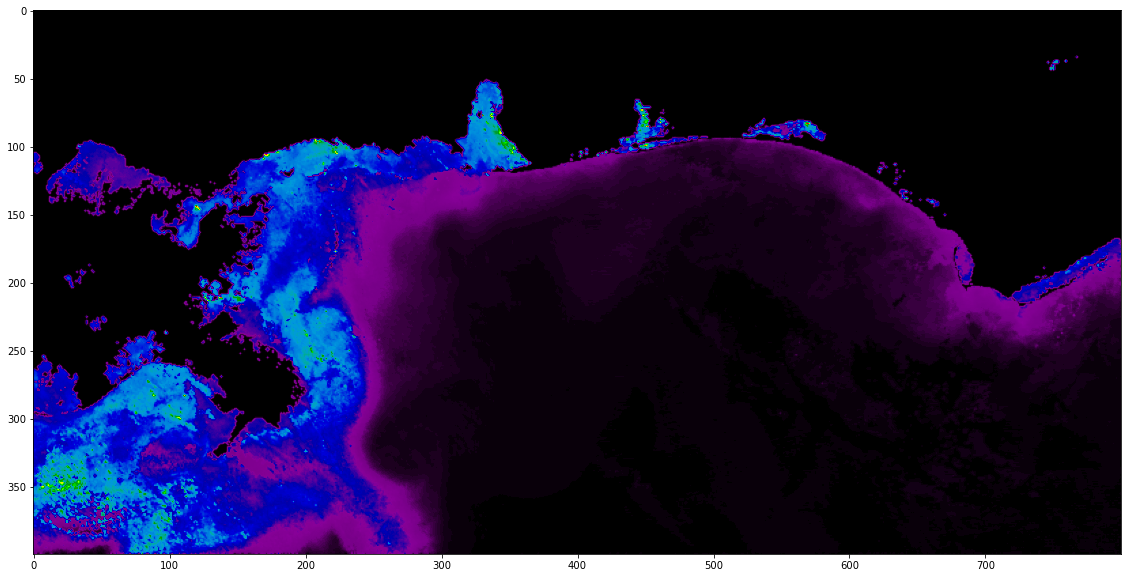

In [17]:
from matplotlib import pyplot as plt
plt.figure(figsize = (40,10))
plt.imshow(output_products[var],cmap='nipy_spectral')

In [18]:
#CLOSE ALL FILES
debug.msg_info("Closing out NetCDF files.")
try:
    output_netcdf.close()
except Exception as e:
    failure_management("Failed to close output (seed) NetCDF, you could have a corrupted file.", str(e))

try:
    aps_netcdf.close()
except Exception as e:
    failure_management("Failed to close the input APS NetCDF.  Caution, this could result in a corrupted file.", str(e))

try:
    biocast_netcdf.close()
except Exception as e:
    failure_management("Failed to close the input BIOCAST NetCDF.  Caution, this could result in a corrupted file.", str(e))

debug.msg_info("Finished " + str(VERSION_NAME) + ".")

[2022-09-07 16:28:30 CDT]    INFO: Closing out NetCDF files. 
[2022-09-07 16:28:30 CDT]    INFO: Finished OFM_seed_generator. 
